<a href="https://colab.research.google.com/github/Ziyi-star/Bachelorarbeit/blob/main/notebooks/training/train_simclr_har_0.5s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SimCLR Training

In [ ]:
# For VSCode
%load_ext autoreload
%autoreload 2

import os
import pickle
import scipy
import datetime
import numpy as np
import tensorflow as tf
import simclr_utitlities
import transformations
import simclr_models
import sys
import matplotlib.pyplot as plt

sys.path.append('../')   # Add parent directory to Python path
working_directory = "../models/"

seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

with open('../data_all/TrainTest/X_train_normalized.pkl', 'rb') as f:
    np_train_data = pickle.load(f)
with open('../data_all/TrainTest/y_train_onehot.pkl', 'rb') as f:
    np_train_labels = pickle.load(f)
with open('../data_all/TrainTest/X_val_normalized.pkl', 'rb') as f:
    np_val_data = pickle.load(f)
with open('../data_all/TrainTest/y_val_onehot.pkl', 'rb') as f:
    np_val_labels = pickle.load(f)
with open('../data_all/TrainTest/X_test_data.pkl', 'rb') as f:
    np_test_data = pickle.load(f)
with open('../data_all/TrainTest/y_test_onehot.pkl', 'rb') as f:
    np_test_labels = pickle.load(f)

np_train_data.shape, np_train_labels.shape, np_val_data.shape, np_val_labels.shape, np_test_labels.shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


((5254, 50, 3), (5254, 7), (1314, 50, 3), (1314, 7), (1643, 7))

In [3]:
# For Google Colab
# 1. Clone your repository to go to access your notebook and .py files
!git clone https://github.com/Ziyi-star/Bachelorarbeit.git
# 2. Change working directory to where your notebook and .py files are
import os
os.chdir('/content/Bachelorarbeit/notebooks/training')
import os
import pickle
import scipy
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import simclr_utitlities
import transformations
import simclr_models
import sys

seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

# Load data
# Download the file from GitHub
!rm -f *.pkl # Remove existing pickle files
!wget https://raw.githubusercontent.com/Ziyi-star/Bachelorarbeit/main/notebooks/data_all/TrainTest/X_train_normalized.pkl
!wget https://raw.githubusercontent.com/Ziyi-star/Bachelorarbeit/main/notebooks/data_all/TrainTest/y_train_onehot.pkl
!wget https://raw.githubusercontent.com/Ziyi-star/Bachelorarbeit/main/notebooks/data_all/TrainTest/X_val_normalized.pkl
!wget https://raw.githubusercontent.com/Ziyi-star/Bachelorarbeit/main/notebooks/data_all/TrainTest/y_val_onehot.pkl
!wget https://raw.githubusercontent.com/Ziyi-star/Bachelorarbeit/main/notebooks/data_all/TrainTest/X_test_data.pkl
!wget https://raw.githubusercontent.com/Ziyi-star/Bachelorarbeit/main/notebooks/data_all/TrainTest/y_test_onehot.pkl


working_directory = "../models/"  # Relative path to models folder

# Load as usual
import pickle

with open('X_train_normalized.pkl', 'rb') as f:
    np_train_data = pickle.load(f)
with open('y_train_onehot.pkl', 'rb') as f:
    np_train_labels = pickle.load(f)
with open('X_val_normalized.pkl', 'rb') as f:
    np_val_data = pickle.load(f)
with open('y_val_onehot.pkl', 'rb') as f:
    np_val_labels = pickle.load(f)
with open('X_test_data.pkl', 'rb') as f:
    np_test_data = pickle.load(f)
with open('y_test_onehot.pkl', 'rb') as f:
    np_test_labels = pickle.load(f)

print(np_train_data.shape, np_train_labels.shape)
print(np_val_data.shape, np_val_labels.shape)

Cloning into 'Bachelorarbeit'...
remote: Enumerating objects: 449, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 449 (delta 24), reused 37 (delta 16), pack-reused 399 (from 2)
Receiving objects: 100% (449/449), 144.36 MiB | 27.31 MiB/s, done.
Resolving deltas: 100% (249/249), done.
Updating files: 100% (69/69), done.
--2025-09-18 11:02:57--  https://raw.githubusercontent.com/Ziyi-star/Bachelorarbeit/main/notebooks/data_all/TrainTest/X_train_normalized.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6304965 (6.0M) [application/octet-stream]
Saving to: ‘X_train_normalized.pkl’

X_train_normalized. 100%[===================>]   6.01M  --.-KB/s    in 0.06s   

2025-09-18 11:02:58 (92.7 MB/s)

## 1.1 Pretraining with SimCLR

In [5]:
# Parameters for all experiments
window_size = 50
input_shape = (window_size, 3)
batch_size = 512
#Number of samples processed together in one training step. Larger batch sizes can speed up training but require more memory.
decay_steps = 1000
#Number of steps after which the learning rate decays (used for learning rate scheduling).
epochs = 200
temperature = 0.1


In [ ]:
# # transformation_indices = [2] # Use rotation transformation only
# # transformation_indices = [1, 2] # Use Scaling and rotation transformation
# transformation_indices = [5, 7] # Use channel shuffle and permutation transformation

# transform_funcs_vectorized = [
#     # 0. Adding random Gaussian noise.
#     transformations.noise_transform_vectorized,
#     # 1. Scaling by a random factor
#     transformations.scaling_transform_vectorized,
#     # 2. Applying a random 3D rotation
#     transformations.rotation_transform_vectorized,
#     # 3. Inverting the signals.
#     transformations.negate_transform_vectorized,
#     # 4. Reversing the direction of time
#     transformations.time_flip_transform_vectorized,
#     # 5. Randomly scrambling sections of the signal.
#     transformations.time_segment_permutation_transform_improved,
#     # 6. Stretching and warping the time-series
#     transformations.time_warp_transform_low_cost,
#     # 7. Shuffling the different channels.
#     transformations.channel_shuffle_transform_vectorized
# ]
# # transform_funcs_names = ['noised', 'scaled', 'rotated', 'negated', 'time_flipped', 'permuted', 'time_warped', 'channel_shuffled']
# # Optionally, you can use a combined transformation function for data augmentation.
# transformation_function = simclr_utitlities.generate_combined_transform_function(
#     transform_funcs_vectorized,
#     indices=transformation_indices
# )

In [6]:
#A parameter for the SimCLR loss function that controls how sharply similarities are measured.
# transform_funcs = [
#     transformations.scaling_transform_vectorized, # Use Scaling trasnformation
#     transformations.rotation_transform_vectorized # Use rotation trasnformation
# ]
transform_funcs = [
    transformations.time_segment_permutation_transform_improved,
    transformations.channel_shuffle_transform_vectorized
]
#List of data augmentation functions to apply to the input data. Here, only rotation is used.
transformation_function = simclr_utitlities.generate_composite_transform_function_simple(transform_funcs)

0 <function time_segment_permutation_transform_improved at 0x7b5a726e8540>
1 <function channel_shuffle_transform_vectorized at 0x7b5a726e84a0>


In [7]:
# Time
start_time = datetime.datetime.now()
start_time_str = start_time.strftime("%Y%m%d-%H%M%S")
#Formats the date and time as a string like 20250827-153045 (for filenames, logs, etc.).
tf.keras.backend.set_floatx('float32')
#Sets TensorFlow to use 32-bit floating point numbers for all computations (standard for deep learning).


In [8]:
# Create a cosine-decayed learning rate schedule and SGD optimizer for training.
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

# Build the base model and attach the SimCLR head for contrastive learning.
base_model = simclr_models.create_base_model(input_shape, model_name="base_model")
simclr_model = simclr_models.attach_simclr_head(base_model)
simclr_model.summary()

# Train the SimCLR model using the specified transformation function and optimizer.
trained_simclr_model, epoch_losses = simclr_utitlities.simclr_train_model(
    simclr_model,
    np_train_data,
    optimizer,
    batch_size,
    transformation_function,
    temperature=temperature,
    epochs=epochs,
    is_trasnform_function_vectorized=True,
    verbose=1
)

# Save the trained SimCLR model to disk for later use.
simclr_model_save_path = f"{working_directory}{start_time_str}_simclr.hdf5"
trained_simclr_model.save(simclr_model_save_path)

Model: "base_model_simclr"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 50, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 27, 32)         │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 27, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5, 96)          │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 96)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         6,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,594 (580.45 KB)

 Trainable params: 148,594 (580.45 KB)

 Non-trainable params: 0 (0.00 B)

epoch: 1 loss: 11.931
epoch: 2 loss: 10.769
epoch: 3 loss: 10.190
epoch: 4 loss: 9.768
epoch: 5 loss: 10.234
epoch: 6 loss: 9.192
epoch: 7 loss: 9.152
epoch: 8 loss: 8.635
epoch: 9 loss: 8.298
epoch: 10 loss: 7.958
epoch: 11 loss: 7.943
epoch: 12 loss: 8.189
epoch: 13 loss: 7.683
epoch: 14 loss: 7.292
epoch: 15 loss: 7.005
epoch: 16 loss: 6.622
epoch: 17 loss: 6.597
epoch: 18 loss: 6.459
epoch: 19 loss: 6.063
epoch: 20 loss: 6.071
epoch: 21 loss: 5.983
epoch: 22 loss: 5.797
epoch: 23 loss: 5.732
epoch: 24 loss: 5.752
epoch: 25 loss: 5.579
epoch: 26 loss: 5.395
epoch: 27 loss: 5.228
epoch: 28 loss: 5.188
epoch: 29 loss: 5.055
epoch: 30 loss: 5.127
epoch: 31 loss: 5.103
epoch: 32 loss: 5.002
epoch: 33 loss: 4.732
epoch: 34 loss: 4.726
epoch: 35 loss: 4.653
epoch: 36 loss: 4.521
epoch: 37 loss: 4.689
epoch: 38 loss: 4.383
epoch: 39 loss: 4.345
epoch: 40 loss: 4.289
epoch: 41 loss: 4.194
epoch: 42 loss: 4.138
epoch: 43 loss: 4.014
epoch: 44 loss: 3.895
epoch: 45 loss: 3.928
epoch: 46 loss:

epoch: 200 loss: 2.698


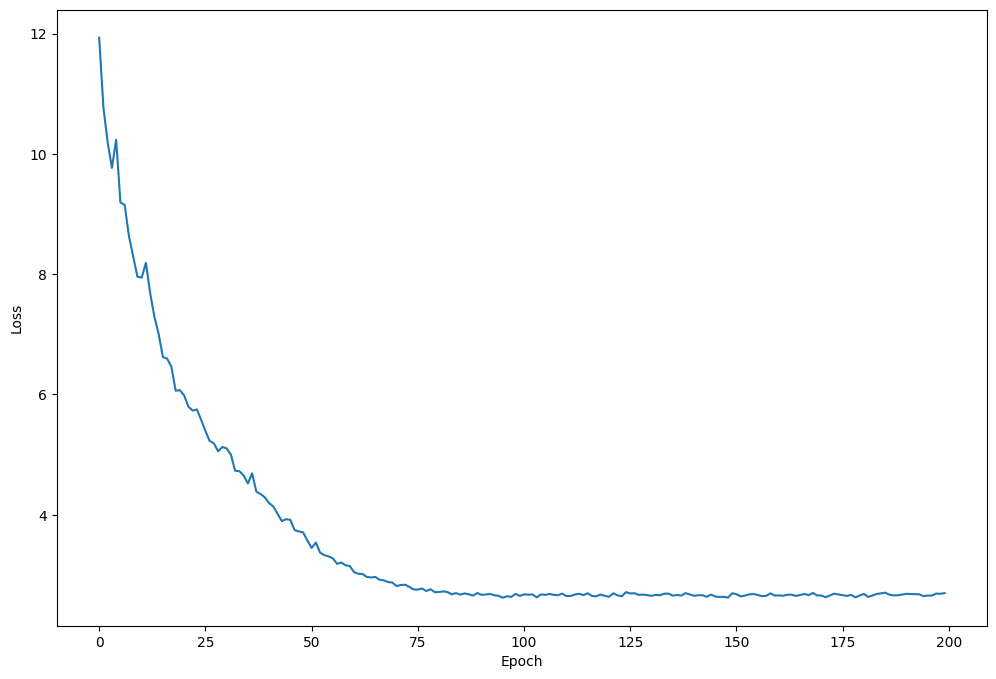

In [9]:
# Plot history of training losses over epochs.
plt.figure(figsize=(12,8))
plt.plot(epoch_losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

## 1.2 Fine-tuning and Evaluation

### 1.2.1 Linear Model

#### Train

In [10]:
# This block performs linear evaluation on top of the pretrained SimCLR base model.
total_epochs = 50
batch_size = 200
tag = "linear_eval"
output_shape = np_train_labels.shape[1]  # Number of classes for classification

# 1. Loads the SimCLR model and attaches a linear classification head on top.
simclr_model = tf.keras.models.load_model(simclr_model_save_path)
linear_evaluation_model = simclr_models.create_linear_model_from_base_model(simclr_model, output_shape, intermediate_layer=7)

# 2. Sets up a ModelCheckpoint callback to save the best model (lowest validation loss).
# This ensures we keep the model version that performs best on validation data
linear_eval_best_model_file_name = f"{working_directory}{start_time_str}_simclr_{tag}.keras"
best_model_callback = tf.keras.callbacks.ModelCheckpoint(
    linear_eval_best_model_file_name,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

# 3. Trains the linear evaluation model using the training and validation data.
training_history = linear_evaluation_model.fit(
    x = np_train_data,
    y = np_train_labels,
    batch_size=batch_size,
    shuffle=True,
    epochs=total_epochs,
    callbacks=[best_model_callback],
    validation_data=(np_val_data, np_val_labels)
)



Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - auc: 0.6307 - categorical_accuracy: 0.2430 - loss: 2.0577 - precision: 0.4217 - recall: 0.1089 - val_auc: 0.8080 - val_categorical_accuracy: 0.4521 - val_loss: 1.4788 - val_precision: 0.8821 - val_recall: 0.1651
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.7872 - categorical_accuracy: 0.4305 - loss: 1.5714 - precision: 0.7287 - recall: 0.1704 - val_auc: 0.8245 - val_categorical_accuracy: 0.4970 - val_loss: 1.4192 - val_precision: 0.8769 - val_recall: 0.1735
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.8061 - categorical_accuracy: 0.4606 - loss: 1.4891 - precision: 0.7481 - recall: 0.1806 - val_auc: 0.8327 - val_categorical_accuracy: 0.5084 - val_loss: 1.3895 - val_precision: 0.8682 - val_recall: 0.1956
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.8211 - categorical_accuracy: 0.4818 - loss: 1.4294 - precision: 0.7678 - recall: 0.1877 - val_auc: 0.8376 - val_categorical_accuracy: 0.5107 - val

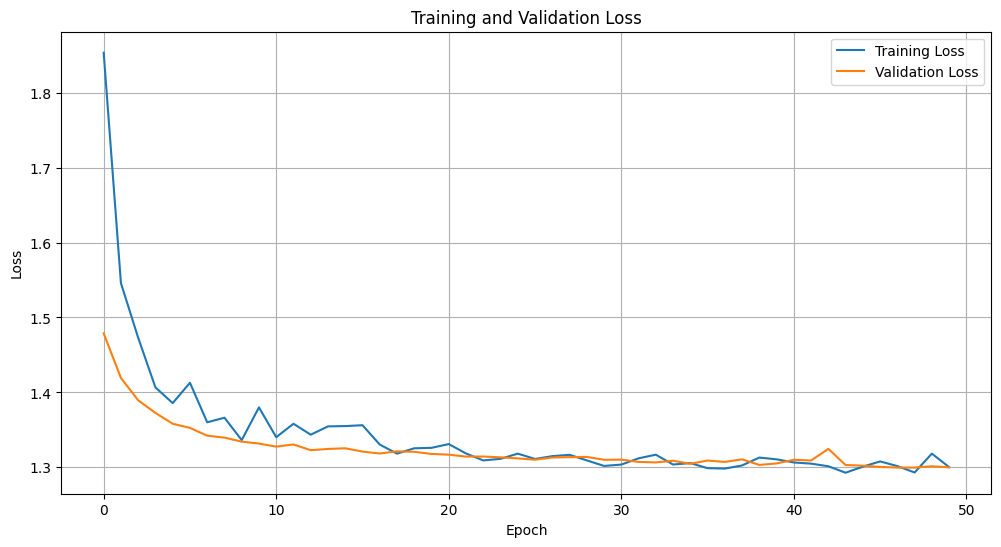

In [11]:
# Training and Validation Loss

plt.figure(figsize=(12,6))
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

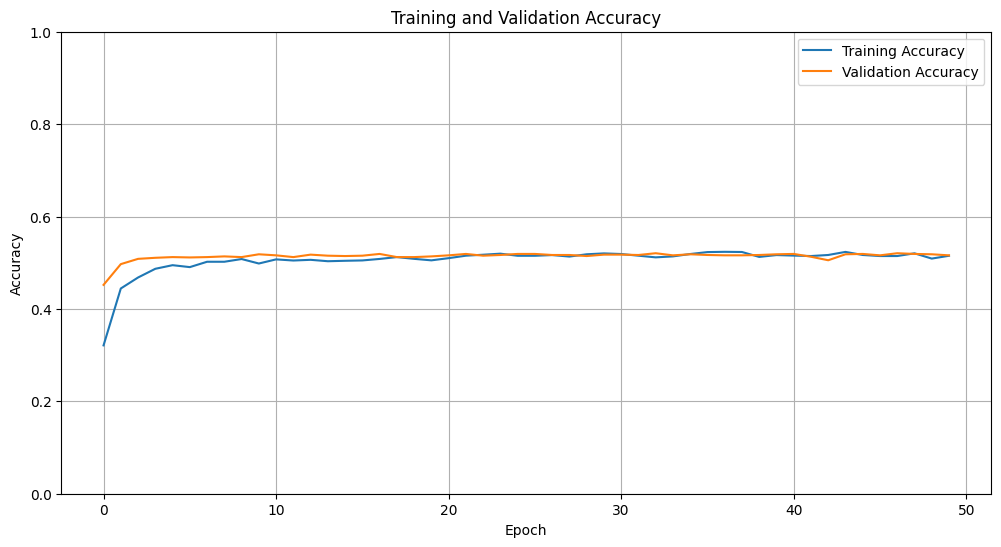

In [13]:
# Training and Validation Accuracy
plt.figure(figsize=(12,6))
plt.plot(training_history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0, 1])
plt.show()

#### Test:

In [ ]:
# Load models and evaluate on test set on vscode
# simclr_model_path = "../models/20250918-072951_simclr.hdf5"
linear_eval_model_path = "../models/20250918-072951_simclr_linear_eval.keras"

# Load both models
# simclr_model = tf.keras.models.load_model(simclr_model_path)
linear_eval_best_model = tf.keras.models.load_model(linear_eval_model_path)

#### Normalize test data

In [14]:
from sklearn.preprocessing import StandardScaler

def normalize_3d_data(data):
    """
    Normalize 3D sensor data (samples, timesteps, features) using StandardScaler.

    Parameters:
    -----------
    data : list or numpy.ndarray
        Input data. If a list of arrays, it will be stacked first.
        Shape should be (N, L, C) where:
        N = number of samples, L = segment length (timesteps), C = number of channels/features

    Returns:
    --------
    numpy.ndarray
        Normalized data with the same shape as input
    """
    # Stack data if it's a list
    if isinstance(data, list):
        data_array = np.stack(data)  # shape: (N, L, C)
    else:
        data_array = data

    # Get dimensions
    N, L, C = data_array.shape

    # Reshape to 2D for scaling: (N*L, C)
    data_reshaped = data_array.reshape(-1, C)

    # Apply standard scaling
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_reshaped)

    # Reshape back to original 3D shape
    data_normalized = data_scaled.reshape(N, L, C)

    return data_normalized

In [15]:
# You can also use it for test data (but should fit the scaler only on training data)
X_test_normalized = normalize_3d_data(np_test_data)

In [16]:
linear_eval_best_model = tf.keras.models.load_model(linear_eval_best_model_file_name)

print("Model with lowest validation Loss:")
print(simclr_utitlities.evaluate_model_simple(linear_eval_best_model.predict(X_test_normalized), np_test_labels, return_dict=True))
print("Model in last epoch")
print(simclr_utitlities.evaluate_model_simple(linear_evaluation_model.predict(X_test_normalized), np_test_labels, return_dict=True))


Model with lowest validation Loss:
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
{'Confusion Matrix': array([[227,   5,   2,  14,   1,  13,  21],
       [ 16, 119,   2,  10,  28,  17,   5],
       [ 90,  17,   0,  16,   5,  38,  28],
       [ 23,   6,   0, 136,   1,  46,  26],
       [  0,  19,   0,   7, 201,   9,   2],
       [ 38,   8,   2,  21,   0, 120,  44],
       [116,   5,   1,  20,   3,  58,  57]]), 'F1 Macro': 0.47768208726628625, 'F1 Micro': 0.5234327449786975, 'F1 Weighted': 0.48633193174823264, 'Precision': 0.4668851508448979, 'Recall': 0.5080570957230285, 'Kappa': np.float64(0.4383680892835081)}
Model in last epoch
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
{'Confusion Matrix': array([[228,   4,   3,  15,   1,  13,  19],
       [ 16, 110,   3,   9,  37,  17,   5],
       [ 91,  16,   0,  16,   6,  35,  30],
       [ 23,   5,   0, 138,   2,  46,  24],
       [  0,  16,   0,   8, 204,   8,   2],
       [ 39,   5,   2,  21,   0, 123,  43],
       [115,   3,   2,  22,   3,  58,  57]]), 

### 1.2.2 Full HAR Model

#### Train

In [21]:
total_epochs = 200
batch_size = 200
tag = "full_eval"

simclr_model = tf.keras.models.load_model(simclr_model_save_path)
full_evaluation_model = simclr_models.create_full_classification_model_from_base_model(simclr_model, output_shape, model_name="TPN", intermediate_layer=7, last_freeze_layer=4)

full_eval_best_model_file_name = f"{working_directory}{start_time_str}_simclr_{tag}.keras"

best_model_callback = tf.keras.callbacks.ModelCheckpoint(full_eval_best_model_file_name,
    monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=0
)

training_history = full_evaluation_model.fit(
    x = np_train_data,
    y = np_train_labels,
    batch_size=batch_size,
    shuffle=True,
    epochs=total_epochs,
    callbacks=[best_model_callback],
    validation_data=(np_val_data, np_val_labels)
)



Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 244ms/step - auc: 0.7367 - categorical_accuracy: 0.3717 - loss: 1.6685 - precision: 0.6806 - recall: 0.1594 - val_auc: 0.8547 - val_categorical_accuracy: 0.5236 - val_loss: 1.3056 - val_precision: 0.8133 - val_recall: 0.2519
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8510 - categorical_accuracy: 0.5116 - loss: 1.3178 - precision: 0.7310 - recall: 0.2729 - val_auc: 0.8666 - val_categorical_accuracy: 0.5365 - val_loss: 1.2552 - val_precision: 0.8068 - val_recall: 0.2892
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8625 - categorical_accuracy: 0.5263 - loss: 1.2645 - precision: 0.7355 - recall: 0.3173 - val_auc: 0.8702 - val_categorical_accuracy: 0.5342 - val_loss: 1.2331 - val_precision: 0.7938 - val_recall: 0.3105
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8675 - categorical_accuracy: 0.5303 - loss: 1.2383 - precision: 0.7413 - recall: 0.3352 - val_auc: 0.8735 - val_categorical_accuracy: 0.5388 -

#### Plot metrics

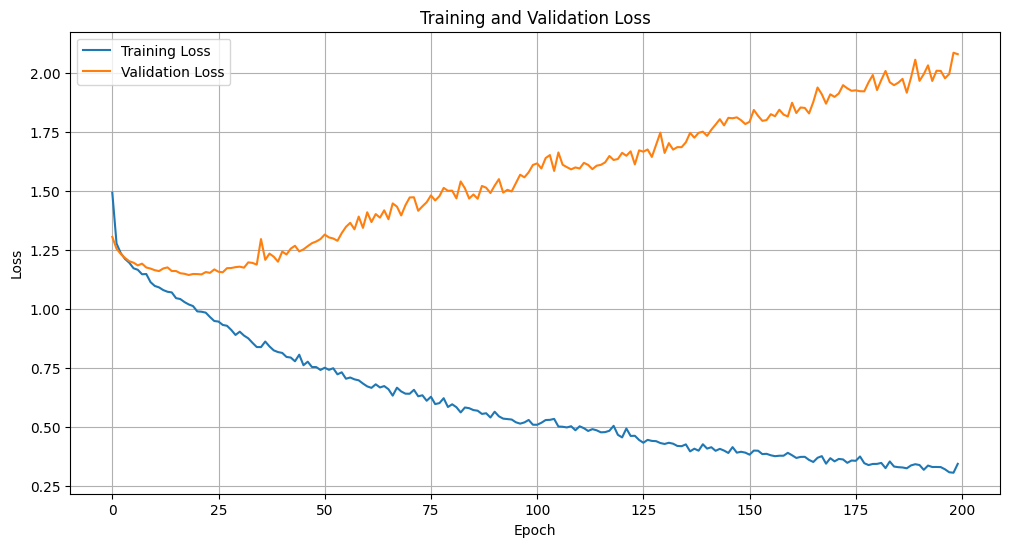

In [22]:
# Training and Validation Loss

plt.figure(figsize=(12,6))
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

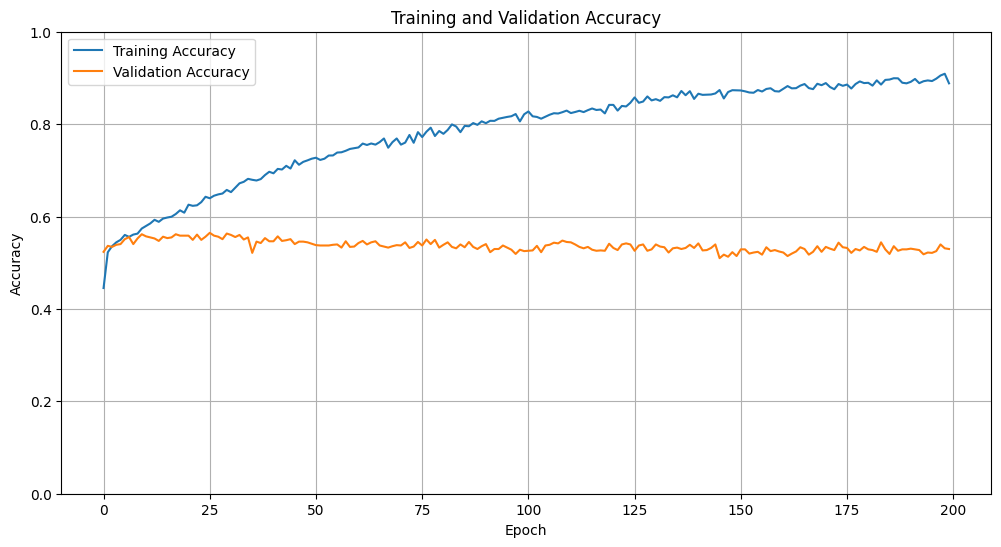

In [24]:
# Training and Validation Accuracy
plt.figure(figsize=(12,6))
plt.plot(training_history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0, 1])
plt.show()

#### Test:

In [25]:
full_eval_best_model = tf.keras.models.load_model(full_eval_best_model_file_name)

print("Model with lowest validation Loss:")
print(simclr_utitlities.evaluate_model_simple(full_eval_best_model.predict(X_test_normalized), np_test_labels, return_dict=True))
print("Model in last epoch")
print(simclr_utitlities.evaluate_model_simple(full_evaluation_model.predict(X_test_normalized), np_test_labels, return_dict=True))


Model with lowest validation Loss:
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
{'Confusion Matrix': array([[205,   6,  10,  11,   3,   7,  41],
       [ 14, 140,   7,   5,   8,  15,   8],
       [ 78,  14,  21,  10,  10,  29,  32],
       [ 18,   9,   5, 140,   2,  33,  31],
       [  0,  11,   2,   4, 213,   3,   5],
       [ 30,   8,   9,  21,   0, 118,  47],
       [ 88,   5,  23,   9,   4,  43,  88]]), 'F1 Macro': 0.5443476074638233, 'F1 Micro': 0.5629945222154595, 'F1 Weighted': 0.5486947427743813, 'Precision': 0.5548671118754042, 'Recall': 0.5530545043731532, 'Kappa': np.float64(0.4861883674872939)}
Model in last epoch
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
{'Confusion Matrix': array([[163,   5,  22,  17,   1,  23,  52],
       [ 10, 134,  10,  12,   1,  25,   5],
       [ 59,   8,  41,  16,   6,  38,  26],
       [ 13,   7,   5, 150,   1,  44,  18],
       [  2,  14,   8,   7, 195,   7,   5],
       [ 19,   6,  20,  24,   0, 128,  36],
       [ 77,   8,  25,  22,   0,  74,  54]]), 